# Experiments results 

- Experiment 1: MACHO (PT) - Ogle (FT)
- Experiment 2: MACHO (PT) - Subsets of Ogle (FT) (20 - 50 - 100 observations per class)

In [1]:
cd /tf/astromer

/tf/astromer


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # comment to disable GPU
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
from tensorflow.core.util import event_pb2
from tensorflow.python.lib.io import tf_record
from tensorboard.backend.event_processing import event_accumulator
from sklearn.metrics import confusion_matrix
from core.plots import plot_cm

def my_summary_iterator(path):
    for r in tf_record.tf_record_iterator(path):
        yield event_pb2.Event.FromString(r)

def get_metrics(path_logs):
    train_logs = [x for x in os.listdir(path_logs) if x.endswith('.v2')][0]
    path_train = os.path.join(path_logs, train_logs)

    ea = event_accumulator.EventAccumulator(path_train)
    ea.Reload()

    metrics = {tag:[] for tag in ea.Tags()['tensors']}
    for e in my_summary_iterator(path_train):
        for v in e.summary.value:
            if v.tag == 'model': continue
            value = tf.make_ndarray(v.tensor)
            metrics[v.tag].append(value)
    return metrics

def load_weights(model, weights_path):
    model.load_weights(weights_path)
    model.trainable=False
    return model

In [4]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

## Experiment 1: Pretraning on MACHO - Finetuning on Ogle

In [5]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os

from presentation.experiments.exp_1_old import get_mlp, get_lstm, get_lstm_att, init_astromer
from sklearn.metrics import precision_recall_fscore_support
from core.data import load_records

In [6]:
astromer_weights = './weights/astromer_10022021/finetuning/alcock'
exp_folder = './experiments/alcock/'
data_exp = './data/records/alcock/'

In [9]:
encoder = init_astromer(astromer_weights)

In [10]:
test_obj_df = pd.read_csv(data_exp+'test_objs.csv')

classes_name = list(test_obj_df['class'].unique())
print(classes_name)
num_classes = len(classes_name)

['Cep_0', 'Cep_1', 'EC', 'LPV', 'RRab', 'RRc']


In [11]:
test_batches = load_records(data_exp+'/test', batch_size=128, 
                            max_obs=200,
                            msk_frac=0., rnd_frac=0., same_frac=0., 
                            repeat=5,
                            is_train=True) # repeat 1 == no repeat

Training Mode


In [21]:
from core.encoder import Encoder, EncoderLayer
from core.attention import MultiHeadAttention

In [22]:
lstm     = tf.keras.models.load_model('./experiments/alcock/lstm_att/model.h5', 
                                      custom_objects={'Encoder': Encoder, 
                                                      'EncoderLayer': EncoderLayer,
                                                      'MultiHeadAttention':MultiHeadAttention
                                                     })
# lstm_att = get_lstm_att(256, num_classes, encoder=encoder, dropout=0.5)
# mlp_att  = get_mlp(exp_folder+'/mlp_att/model/')

In [11]:
lstm     = load_weights(lstm, exp_folder+'/lstm/weights')
lstm_att = load_weights(lstm_att, exp_folder+'/lstm_att/weights')

In [12]:
%%time
lstm_results     = {'name': 'LSTM', 'y_pred': [], 'y_true': [], 'cce': []}
mlp_att_results  = {'name': 'MLP+ATT', 'y_pred': [], 'y_true': [], 'cce': []}
lstm_att_results = {'name': 'LSTM+ATT', 'y_pred': [], 'y_true': [], 'cce': []}

for batch in test_batches:
    acc, ce, y_pred, y_true = valid_step(lstm, batch, return_pred=True)
    lstm_results['y_pred'].append(y_pred.numpy())
    lstm_results['y_true'].append(y_true.numpy())
    lstm_results['cce'].append(ce.numpy())
        
    acc, ce, y_pred, y_true = valid_step(lstm_att, batch, return_pred=True)
    lstm_att_results['y_pred'].append(y_pred.numpy())
    lstm_att_results['y_true'].append(y_true.numpy())
    lstm_att_results['cce'].append(ce.numpy())
        

try:
    mlp_att_results['y_pred'] = mlp_att.predict(test_embs)
    mlp_att_results['y_true'] = np.concatenate([np.argmax(y_true, 1) for _, y_true in test_embs], 0)
    mlp_att_results['cce'] = mlp_att.evaluate(test_embs)[0]
except:
    pass

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:591: UserWarning: Input dict contained keys ['lcid', 'length', 'label', 'output', 'mask_out', 'mean'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:591: UserWarning: Input dict contained keys ['lcid', 'length', 'label', 'output', 'mask_out', 'mean', 'obserr'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


5/5 [==============================] - 0s 51ms/step - loss: 1.4317 - accuracy: 0.3667
CPU times: user 2min 20s, sys: 10.4 s, total: 2min 31s
Wall time: 34.7 s


In [13]:
def concat_batches_results(results):
    results['y_pred'] = np.concatenate(results['y_pred'], 0)
    results['y_true'] = np.concatenate(results['y_true'], 0)
    results['cce'] = np.mean(results['cce'], 0)
    return results

In [14]:
lstm_results     = concat_batches_results(lstm_results)
lstm_att_results = concat_batches_results(lstm_att_results)

In [56]:
lstm_s = [0.09, 0.10, 0.09, 0.11]
mlp_s = [0.48, 0.56, 0.55, 0.66]
lstm_att_s = [0.58, 0.63, 0.62, 0.75]

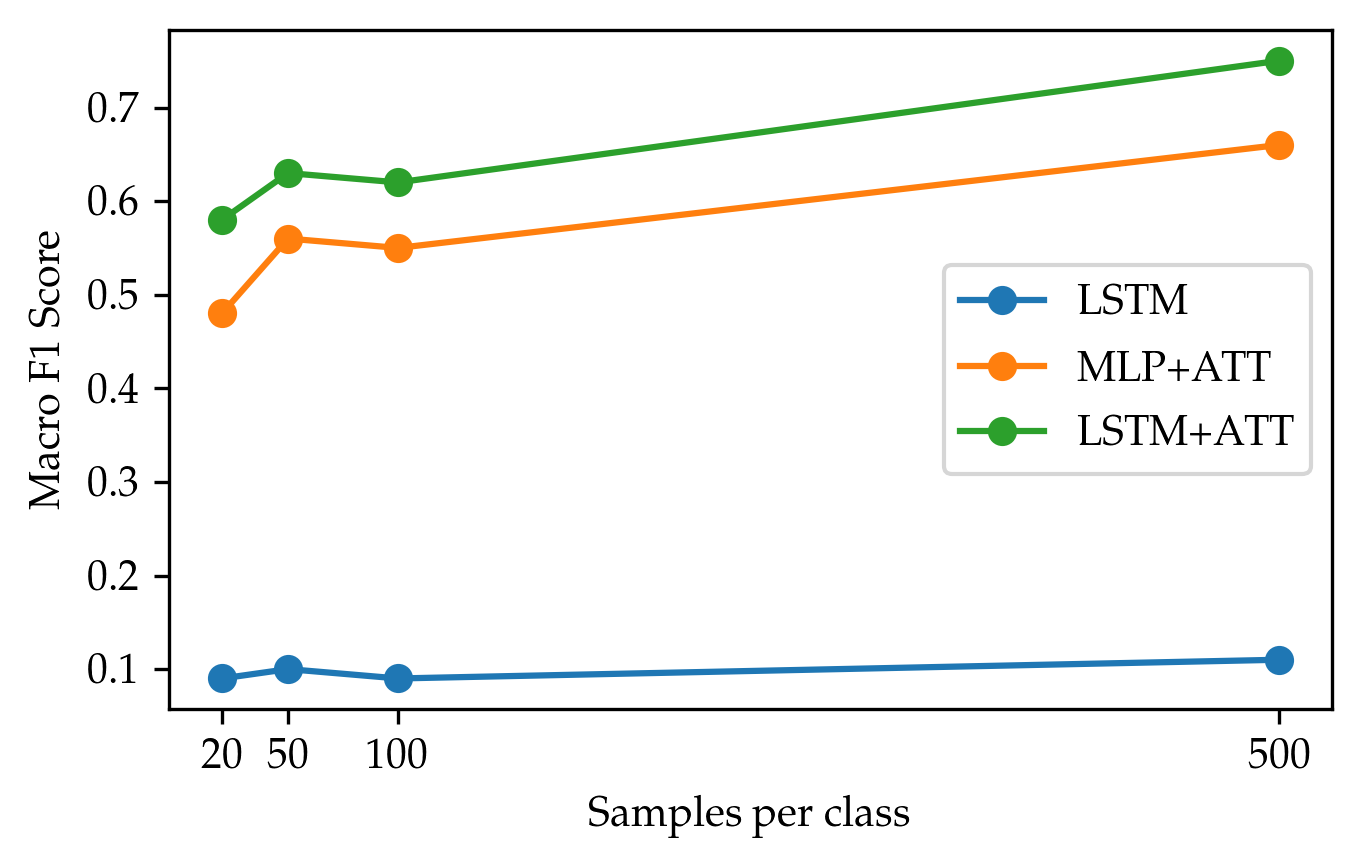

In [57]:
plt.figure(figsize=(5,3), dpi=300)
x_range = [20, 50, 100, 500]
plt.plot(x_range, lstm_s, marker='o', label='LSTM')
plt.plot(x_range, mlp_s, marker='o', label='MLP+ATT')
plt.plot(x_range, lstm_att_s, marker='o', label='LSTM+ATT')
plt.ylabel('Macro F1 Score')
plt.xlabel('Samples per class')
plt.xticks(x_range)
plt.legend()
plt.show()

In [15]:
print('{} & {} & {} & {} \\\\\hline'.format('Model', 'F1 Score', 'Recall', 'Precision'))
for result in [lstm_results, mlp_att_results, lstm_att_results]:
    if result['name'] == 'MLP+ATT':

        y_pred_lab = np.argmax(result['y_pred'], 1)
    else:
        y_pred_lab = np.argmax(result['y_pred'][:, -1, :], 1)
        
    prec, recall, f1, _ = precision_recall_fscore_support(result['y_true'], 
                                                          y_pred_lab, 
                                                          average='macro')
    
    print('{} & {:.2f} & {:.2f} & {:.2f} \\\\\hline'.format(result['name'], f1, recall, prec))

Model & F1 Score & Recall & Precision \\\hline
LSTM & 0.10 & 0.21 & 0.07 \\\hline
MLP+ATT & 0.26 & 0.37 & 0.27 \\\hline
LSTM+ATT & 0.77 & 0.77 & 0.80 \\\hline


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'epoch_loss': [], 'epoch_accuracy': []}
{'epoch_loss': [], 'epoch_accuracy': []}


Text(0.0, 0.5, 'Categorical Cross Entropy')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


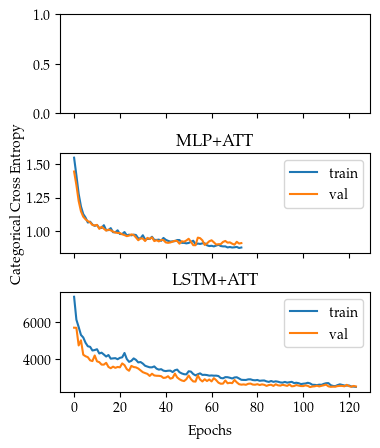

In [16]:
def my_summary_iterator(path):
    for r in tf_record.tf_record_iterator(path):
        yield event_pb2.Event.FromString(r)

def get_metrics_2(path_logs):
    train_logs = [x for x in os.listdir(path_logs) if x.endswith('.v2')][0]
    path_train = os.path.join(path_logs, train_logs)

    ea = event_accumulator.EventAccumulator(path_train)
    ea.Reload()

    metrics = {tag:[] for tag in ea.Tags()['scalars']}
    print(metrics)
    for e in my_summary_iterator(path_train):
        for v in e.summary.value:
            if v.tag == 'batch_2': continue
            value = v.simple_value
            metrics[v.tag].append(value)
    
    
    metrics['xentropy'] = metrics.pop('epoch_loss')
    metrics['accuracy'] = metrics.pop('epoch_accuracy')
    
    return metrics

fig, axes = plt.subplots(3,1, sharex=True, figsize=(4,5), dpi=100, gridspec_kw={'hspace': 0.4, 'wspace': 0},)
for index, name in enumerate(['lstm', 'mlp_att', 'lstm_att']):
    if name =='lstm':continue
    if name =='mlp_att':
        val_metrics = get_metrics_2(os.path.join(
            exp_folder, name, 'logs', 'validation'))
        train_metrics = get_metrics_2(
            os.path.join(exp_folder, name, 'logs', 'train'))
    else:
        val_metrics = get_metrics(os.path.join(
            exp_folder, name, 'logs', 'valid'))
        train_metrics = get_metrics(
            os.path.join(exp_folder, name, 'logs', 'train'))
        
    axes[index].plot(train_metrics['xentropy'], label='train')
    axes[index].plot(val_metrics['xentropy'], label='val')
    if name =='lstm': title_name = 'LSTM'
    if name =='mlp_att': title_name = 'MLP+ATT'
    if name =='lstm_att': title_name = 'LSTM+ATT'
    axes[index].set_title(title_name)
    axes[index].legend()
    
fig.text(0.5, 0.04, 'Epochs', ha='center')
fig.text(0.0, 0.5, 'Categorical Cross Entropy', va='center', rotation='vertical')

{'epoch_loss': [], 'epoch_accuracy': []}
{'epoch_loss': [], 'epoch_accuracy': []}


Text(0.0, 0.5, 'Accuracy')

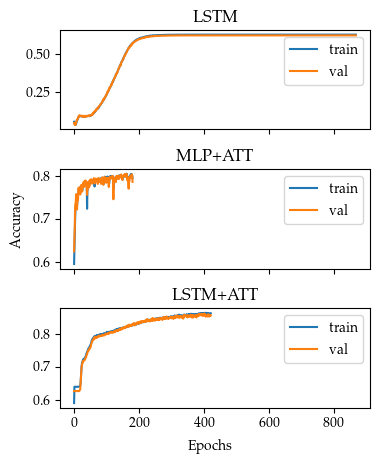

In [30]:
fig, axes = plt.subplots(3,1, sharex=True, figsize=(4,5), dpi=100, gridspec_kw={'hspace': 0.4, 'wspace': 0},)
for index, name in enumerate(['lstm', 'mlp_att', 'lstm_att']):
    if name =='mlp_att':
        val_metrics = get_metrics_2(os.path.join(
            exp_folder, name, 'logs', 'validation'))
        train_metrics = get_metrics_2(
            os.path.join(exp_folder, name, 'logs', 'train'))
    else:
        val_metrics = get_metrics(os.path.join(
            exp_folder, name, 'logs', 'valid'))
        train_metrics = get_metrics(
            os.path.join(exp_folder, name, 'logs', 'train'))
        
    axes[index].plot(train_metrics['accuracy'], label='train')
    axes[index].plot(val_metrics['accuracy'], label='val')
    if name =='lstm': title_name = 'LSTM'
    if name =='mlp_att': title_name = 'MLP+ATT'
    if name =='lstm_att': title_name = 'LSTM+ATT'
    axes[index].set_title(title_name)
    axes[index].legend()
    
fig.text(0.5, 0.04, 'Epochs', ha='center')
fig.text(0.0, 0.5, 'Accuracy', va='center', rotation='vertical')

In [20]:
lstm_cm     = confusion_matrix(lstm_results['y_true'], np.argmax(lstm_results['y_pred'][:, -1, :], 1), normalize='true')
lstm_att_cm = confusion_matrix(lstm_att_results['y_true'], np.argmax(lstm_att_results['y_pred'][:, -1, :], 1), normalize='true')

try:
    mlp_att_cm  = confusion_matrix(mlp_att_results['y_true'], np.argmax(mlp_att_results['y_pred'], 1), normalize='true')
except:
    pass

In [21]:
classes_name = [x.replace('_', '\_') for x in classes_name]

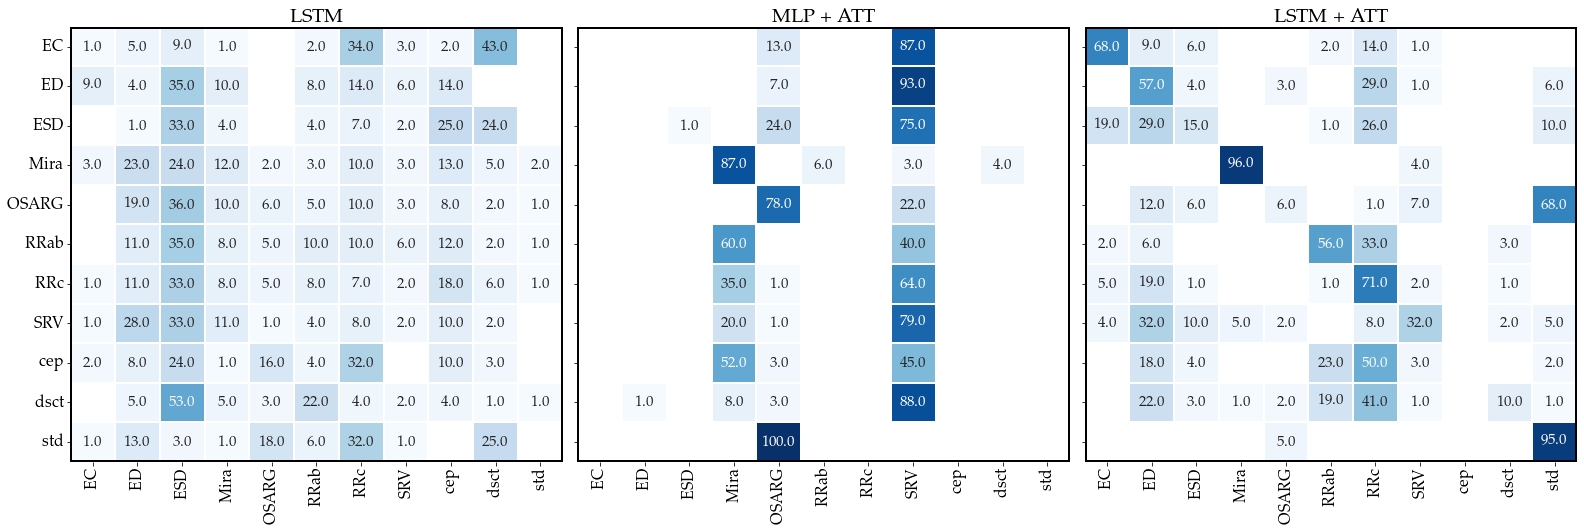

In [22]:
fig, axes = plt.subplots(1,3, figsize=(27,8), sharey=True, gridspec_kw={'hspace': 0., 'wspace': 0.03})

axes[0] = plot_cm(lstm_cm, axes[0], title='LSTM', class_names=classes_name)
axes[1] = plot_cm(mlp_att_cm, axes[1], title='MLP + ATT', class_names=classes_name)
axes[2] = plot_cm(lstm_att_cm, axes[2], title='LSTM + ATT', class_names=classes_name)